In [1]:
import torch # pytorch backend
import torchvision # CV models
import pygmtools as pygm
import matplotlib.pyplot as plt # for plotting
from matplotlib.patches import ConnectionPatch # for plotting matching result
import scipy.io as sio # for loading .mat file
import scipy.spatial as spa # for Delaunay triangulation
from sklearn.decomposition import PCA as PCAdimReduc
import itertools
import numpy as np
from PIL import Image
pygm.BACKEND = 'pytorch' # set default backend for pygmtools

/mnt/xlancefs/home/ycm02/miniconda3/envs/dlfinal_proj/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
ds_dict = {
    'ROOT_DIR' : './data/', 
}

dataset = pygm.dataset.WillowObject(sets='train', obj_resize=(256, 256), ds_dict=ds_dict)

obj_resize = (256, 256)
img1 = Image.open('./data/WillowObject/WILLOW-ObjectClass/Duck/060_0001.png')
img2 = Image.open('./data/WillowObject/WILLOW-ObjectClass/Duck/060_0002.png')
kpts1 = torch.tensor(sio.loadmat('./data/WillowObject/WILLOW-ObjectClass/Duck/060_0001.mat')['pts_coord'])
kpts2 = torch.tensor(sio.loadmat('./data/WillowObject/WILLOW-ObjectClass/Duck/060_0002.mat')['pts_coord'])


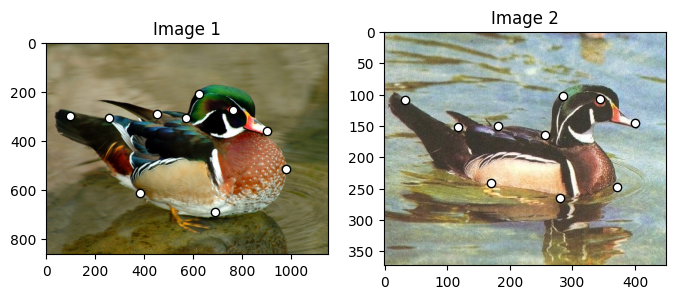

In [9]:
def plot_image_with_graph(img, kpt, A=None):
    plt.imshow(img)
    plt.scatter(kpt[0], kpt[1], c='w', edgecolors='k')
    if A is not None:
        for idx in torch.nonzero(A, as_tuple=False):
            plt.plot((kpt[0, idx[0]], kpt[0, idx[1]]), (kpt[1, idx[0]], kpt[1, idx[1]]), 'k-')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plot_image_with_graph(img1, kpts1)
plt.subplot(1, 2, 2)
plt.title('Image 2')
plot_image_with_graph(img2, kpts2)


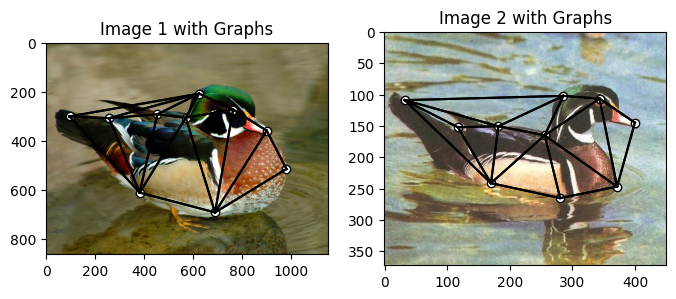

In [11]:
# 搭建graph
def delaunay_triangulation(kpt):
    d = spa.Delaunay(kpt.numpy().transpose())
    A = torch.zeros(len(kpt[0]), len(kpt[0]))
    for simplex in d.simplices:
        for pair in itertools.permutations(simplex, 2):
            A[pair] = 1
    return A

A1 = delaunay_triangulation(kpts1)
A2 = delaunay_triangulation(kpts2)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1 with Graphs')
plot_image_with_graph(img1, kpts1, A1)
plt.subplot(1, 2, 2)
plt.title('Image 2 with Graphs')
plot_image_with_graph(img2, kpts2, A2)

In [12]:
vgg16_cnn = torchvision.models.vgg16_bn(True)
print(vgg16_cnn.features)

/mnt/xlancefs/home/ycm02/miniconda3/envs/dlfinal_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/mnt/xlancefs/home/ycm02/miniconda3/envs/dlfinal_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /mnt/xlancefs/home/ycm02/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:39<00:00, 14.1MB/s] 


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [13]:
class CNNNet(torch.nn.Module):
    def __init__(self, vgg16_module):
        super(CNNNet, self).__init__()
        # The naming of the layers follow ThinkMatch convention to load pretrained models.
        self.node_layers = torch.nn.Sequential(*[_ for _ in vgg16_module.features[:31]])
        self.edge_layers = torch.nn.Sequential(*[_ for _ in vgg16_module.features[31:38]])

    def forward(self, inp_img):
        feat_local = self.node_layers(inp_img)
        feat_global = self.edge_layers(feat_local)
        return feat_local, feat_global

ycm02@fourier's password: 
/bin/bash: 020820: command not found
